[INFO] Project root: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous

TOP-20
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ rank ┃ representation_family             ┃ embedding ┃ mtr_model      ┃ teacher                       ┃ augmentation ┃ rrmse  ┃
┣━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━┫
│ 1    │ augmented + frozen sentence + MTR │ e5_base   │ chain_ERCcv_lr │ teacher_e5_base_chainERCcv_lr │ A20          │ 0.6676 │
├──────┼───────────────────────────────────┼───────────┼────────────────┼───────────────────────────────┼──────────────┼────────┤
│ 2    │ augmented + frozen sentence + MTR │ e5_base   │ chain_ERCcv_lr │ teacher_e5_base_chainERCcv_lr │ A50          │ 0.6737 │
├──────┼───────────────────────────────────┼───────────┼────────────────┼───────────────────────────────┼──────────────┼────────┤
│ 

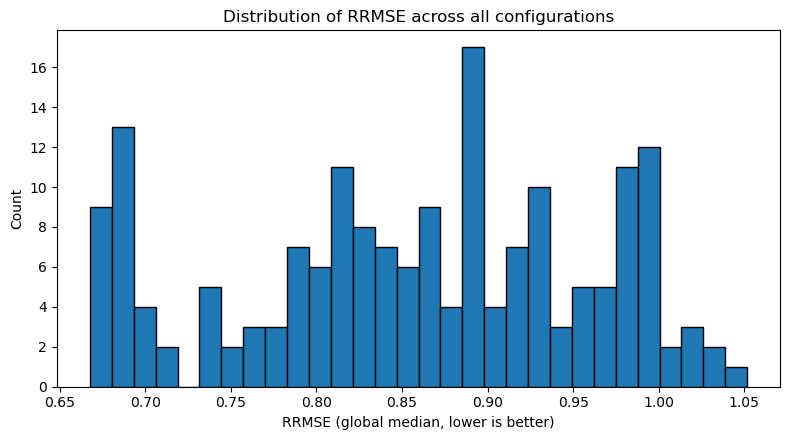

[PLOT] Distribution written → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/plots/rrmse_distribution.png


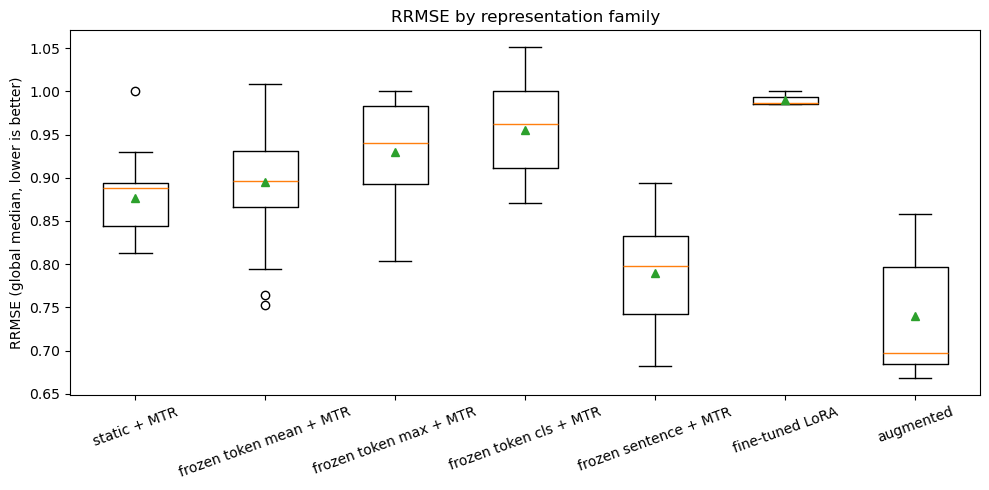

[PLOT] Per-family boxplot written → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/plots/rrmse_boxplot_by_family.png


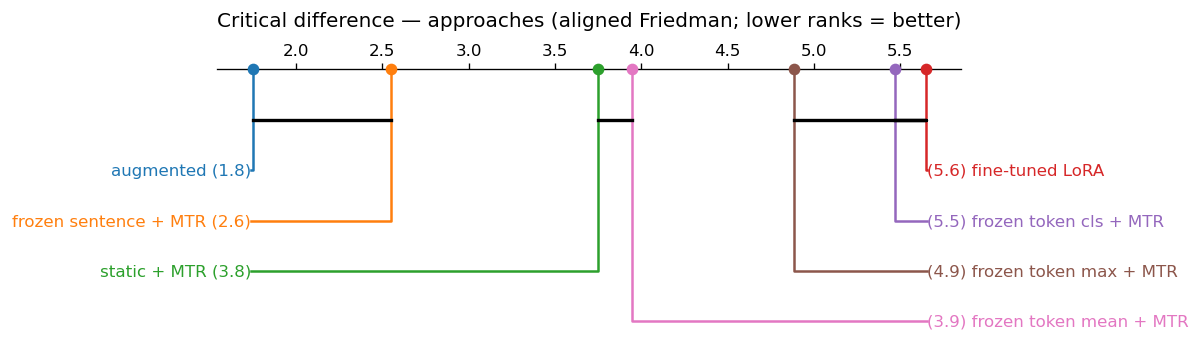

Plot saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/plots/cd_approaches.png

Median RRMSE per fold (sorted low→high):
augmented                  0.733
frozen sentence + MTR      0.786
static + MTR               0.894
frozen token mean + MTR    0.919
frozen token max + MTR     0.941
frozen token cls + MTR     0.966
fine-tuned LoRA            0.987
  ↳ saved → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/r_1_overall/tables/cd_approaches_median.csv

*Aligned-Friedman* (blocks = folds)
  χ²_F = 264.839    F_F = 80.858

*Original-Friedman* (blocks = folds)
  χ²_F = 264.839    p = 2.76e-54    F_F = 80.858

Nemenyi p-values (aligned post-hoc):
                         static + MTR  frozen token mean + MTR  frozen token max + MTR  frozen token cls + MTR  frozen sentence + MTR  fine-tuned LoRA  augmented
static + MTR                   1.0000                   0.9957                  0.0051                  0.0000                 0.00

In [1]:
"""
r_1_overall_leaderboard.ipynb / .py
───────────────────────────────────────────────────────────────────────────────
Overall leaderboard and approach-level statistics across:
  • Static word embeddings + MTR — Word2Vec, FastText (excluding 'mean' regressors).
  • Frozen transformers + MTR — token pooling (mean|max|cls) and sentence encoders.
  • Augmented students (e_3_student_scoring) — ONLY FULL (%K) variants (baseline excluded).
  • Optional: fine-tuned LoRA — if artifacts are present (reported as "fine-tuned LoRA").

This script:
1) Aggregates all available artifacts into a single leaderboard:
   - Ranks configurations by global median RRMSE (lower is better).
   - Writes Top-20 and full leaderboard CSVs.
   - Prints boxed tables to stdout for human-friendly review.

2) Produces summary tables (CSV + boxed print):
   - Breakdown over broad categories: static | frozen | fine-tuned | augmented.
   - Frozen subfamilies: token-mean | token-max | token-cls | sentence.
   - Augmented by size: A10 | A20 | A50 | A100 | A200 | A400.

3) Produces plots (saved under outputs/r_1_overall/plots/ and displayed on screen):
   - rrmse_distribution.png — Histogram over all configurations.
   - rrmse_boxplot_by_family.png — Boxplot over family groups.
   - cd_approaches.png — Critical difference diagram over seven approaches
     ("static + MTR", "frozen token mean + MTR", "frozen token max + MTR",
      "frozen token cls + MTR", "frozen sentence + MTR", "fine-tuned LoRA", "augmented").

   CD diagram construction:
     • For each approach, collect all constituent configurations.
     • Convert each configuration’s (folds×targets) array (or per-fold CSV) to per-fold medians across targets.
     • Aggregate per approach by taking the per-fold median across its configurations.
     • Clip all approaches to the minimum common number of folds and stack as a matrix (rows=folds, cols=approaches).
     • Compute aligned ranks and draw the CD diagram (lower rank = better).

4) Emits approach-level statistical tests to outputs/r_1_overall/tables/ and prints them to stdout:
   - cd_approaches_median.csv — per-approach global medians (across folds).
   - cd_approaches_nemenyi_p.csv — Nemenyi post-hoc p-values (when blocks ≥ 10).
   - cd_approaches_wilcoxon_raw_p.csv — Pairwise Wilcoxon raw p-values.
   - cd_approaches_wilcoxon_holm_p.csv — Holm-Bonferroni adjusted p-values.
   - cd_approaches_cliffs_delta.csv — Pairwise Cliff’s Δ effect sizes.

Inputs (expected on disk):
  Static:
    outputs/a_static/results/baseline_{word2vec|fasttext}_loocv_rrmse.npy
  Frozen:
    outputs/b_frozen/results/*_loocv_rrmse.npy
  Augmented FULL only (baseline excluded):
    outputs/e_3_student_scoring/results/
      rrmse_perfold_{embedding}__{regressor}__{method}__pct{P}_K{K}__Mmax{M}[__labels_*]__full.csv
  Fine-tuned LoRA (optional):
    outputs/d_fine_tuned/results/*_loocv_rrmse.npy

Outputs:
  CSV (outputs/r_1_overall/results/):
    - top20.csv
    - full_leaderboard.csv
    - breakdown_broad.csv
    - breakdown_frozen_subfamilies.csv
    - breakdown_augmented_sizes.csv

  Tables from approach-level stats (outputs/r_1_overall/tables/):
    - cd_approaches_median.csv
    - cd_approaches_nemenyi_p.csv   (if applicable)
    - cd_approaches_wilcoxon_raw_p.csv
    - cd_approaches_wilcoxon_holm_p.csv
    - cd_approaches_cliffs_delta.csv

  Plots (outputs/r_1_overall/plots/):
    - rrmse_distribution.png
    - rrmse_boxplot_by_family.png
    - cd_approaches.png

  Markdown report (reports/leaderboard/leaderboard_report.md):
    - Includes boxed tables and embeds the three figures via relative paths.

Notes:
  • REVIEW_MODE governs execution flow, but both review and compute paths call the same reporting functions.
  • Mean regressors are excluded via a robust token-aware regex (e.g., chain_ERCcv_mean, local_mean).
  • “Augmented” aggregates all FULL variants and teachers into a single approach for the CD analysis.
"""

# ────────────────────────────────────────────
# Imports
# ────────────────────────────────────────────

import os
import re
import sys
import time
import shutil
import warnings
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from itertools import combinations
from scipy.stats import friedmanchisquare, wilcoxon
from statsmodels.stats.multitest import multipletests

warnings.simplefilter("ignore", category=FutureWarning)

# ────────────────────────────────────────────
# Paths
# ────────────────────────────────────────────

def get_project_root(marker: str = "LICENSE") -> Path:
    """Walk up from CWD to find repo root (file marker present)."""
    cwd = Path.cwd().resolve()
    for cand in (cwd, *cwd.parents):
        if (cand / marker).is_file():
            return cand
    return cwd

ROOT = get_project_root()
print(f"[INFO] Project root: {ROOT}")

OUTPUTS_DIR = ROOT / "outputs"
A_STATIC_RES   = OUTPUTS_DIR / "a_static" / "results"
B_FROZEN_RES   = OUTPUTS_DIR / "b_frozen" / "results"
E3_RESULTS_DIR = OUTPUTS_DIR / "e_3_student_scoring" / "results"
FT_RES_DIR     = OUTPUTS_DIR / "d_fine_tuned" / "results"

R1_DIR      = OUTPUTS_DIR / "r_1_overall"
RESULTS_DIR = R1_DIR / "results"
PLOTS_DIR   = R1_DIR / "plots"
TABLES_DIR = R1_DIR / "tables"

for p in (RESULTS_DIR, PLOTS_DIR, TABLES_DIR):
    p.mkdir(parents=True, exist_ok=True)

REPORTS_DIR = ROOT / "reports" / "leaderboard"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# ────────────────────────────────────────────
# Settings / filters
# ────────────────────────────────────────────

REVIEW_MODE   = True

# Robust 'mean' regressor exclusion (token-aware; catches chain_ERCcv_mean, local_mean, global_mean, etc.)
_MEAN_TOKEN_RE = re.compile(r'(^|[_\W])mean($|[_\W])', re.IGNORECASE)
def is_excluded_mtr(model_name: str) -> bool:
    if model_name is None:
        return False
    return bool(_MEAN_TOKEN_RE.search(str(model_name)))

# ────────────────────────────────────────────
# Minimal IO helpers
# ────────────────────────────────────────────

def _canon_teacher_label(labels_tag: str | None) -> str:
    """
    Map an optional labels_tag (e.g., 'labels_local_lasso') to a canonical teacher string.
    Rules match e_3_student_scoring:
      - None / ''                  → 'teacher_e5_base_chainERCcv_lr'
      - 'labels_local_lasso'       → 'teacher_e5_base_local_lasso'
      - any other 'labels_*' value → 'teacher_e5_base_<suffix>'
      - If a value already starts with 'teacher_', return as-is.
    """
    if not labels_tag:
        return "teacher_e5_base_chainERCcv_lr"
    if labels_tag.startswith("teacher_"):
        return labels_tag
    if labels_tag.startswith("labels_"):
        return f"teacher_e5_base_{labels_tag[len('labels_'):]}"
    return labels_tag

def _load_rrmse_artifact(npy_path: Path) -> dict:
    """Return {model_name -> (folds x targets) array} from a saved .npy artifact."""
    arr = np.load(npy_path, allow_pickle=True)
    if isinstance(arr.item(), dict):
        return arr.item()
    raise ValueError(f"Unexpected artifact format in {npy_path.name}")

def discover_static_artifacts() -> dict:
    if not A_STATIC_RES.exists():
        return {}
    mapping = {}
    for f in A_STATIC_RES.glob("baseline_*_loocv_rrmse.npy"):
        emb = f.stem.replace("baseline_", "").replace("_loocv_rrmse", "")
        mapping[emb] = f
    return dict(sorted(mapping.items()))

def discover_frozen_artifacts() -> dict:
    if not B_FROZEN_RES.exists():
        return {}
    mapping = {}
    for f in B_FROZEN_RES.glob("*_loocv_rrmse.npy"):
        key = f.stem.replace("_loocv_rrmse", "")
        mapping[key] = f
    return dict(sorted(mapping.items()))

_E3_PAT = re.compile(
    r"^rrmse_perfold_(?P<emb>.+?)__(?P<reg>.+?)__(?P<meth>.+?)__pct(?P<pct>\d+)_K(?P<K>\d+)__Mmax(?P<M>\d+)"
    r"(?:__(?P<labels>labels_[A-Za-z0-9_]+))?__(?P<var>baseline|full)\.csv$"
)

def discover_augmented_full() -> List[Tuple[str, str, str, int, int, int, str, Path]]:
    """
    Discover augmented FULL rows present on disk (baseline excluded).

    Returns tuples of:
      (embedding, regressor, method, pct, K, M, teacher_canonical, csv_path)
    """
    rows = []
    if not E3_RESULTS_DIR.exists():
        return rows
    for p in E3_RESULTS_DIR.glob("rrmse_perfold_*__*.csv"):
        m = _E3_PAT.match(p.name)
        if not m:
            continue
        if m["var"] != "full":
            continue
        labels_tag = (m.groupdict().get("labels") or "").strip() or None
        teacher = _canon_teacher_label(labels_tag)
        rows.append((
            m["emb"],
            m["reg"],
            m["meth"],
            int(m["pct"]),
            int(m["K"]),
            int(m["M"]),
            teacher,
            p,
        ))
    return sorted(rows)


def discover_finetuned_artifacts() -> dict:
    """Scan for fine-tuned LoRA artifacts under outputs/d_fine_tuned/results/."""
    out = {}
    if not FT_RES_DIR.exists():
        return out
    for f in FT_RES_DIR.glob("*_loocv_rrmse.npy"):
        stem = f.stem.replace("_loocv_rrmse", "")
        # filenames are like: partial_ft_e5_large_loocv_rrmse.npy → embedding 'e5_large'
        if stem.startswith("partial_ft_"):
            stem = stem[len("partial_ft_"):]
        out[stem] = f
    return out

def _global_median_from_aug_csv(p: Path, dom_prefix: str = "rrmse_domain") -> float:
    """Read CSV with per-fold domain columns and return global median over (folds×domains)."""
    df = pd.read_csv(p)
    cols = [c for c in df.columns if c.startswith(dom_prefix)]
    if cols:
        return float(np.median(df[cols].to_numpy(dtype=np.float32).ravel()))
    if "median_rrmse_fold" in df.columns:
        return float(np.median(df["median_rrmse_fold"].to_numpy(dtype=np.float32)))
    raise RuntimeError(f"{p.name}: no '{dom_prefix}*' columns present.")

# ────────────────────────────────────────────
# Representation family classification (no letter codes)
# ────────────────────────────────────────────

def _parse_pooling_from_key(key: str) -> str:
    """Return one of {'token-mean','token-max','token-cls','sentence','static','fine-tuned'}."""
    if key in ("word2vec", "fasttext"):
        return "static"
    if key.endswith("_mean"):
        return "token-mean"
    if key.endswith("_max"):
        return "token-max"
    if key.endswith("_cls"):
        return "token-cls"
    return "sentence"

def _embedding_base_name(key: str) -> str:
    for suff in ("_mean", "_max", "_cls"):
        if key.endswith(suff):
            return key[: -len(suff)]
    return key

# Human-readable family labels without letter prefixes
BASE_FAMILY_LABELS = {
    "static":      "static + MTR",
    "token-mean":  "frozen token mean + MTR",
    "token-max":   "frozen token max + MTR",
    "token-cls":   "frozen token cls + MTR",
    "sentence":    "frozen sentence + MTR",
    "fine-tuned":  "fine-tuned LoRA",
}

def _rep_family_label(pooling_or_kind: str, augmented: bool = False) -> str:
    base = BASE_FAMILY_LABELS.get(pooling_or_kind, "frozen sentence + MTR")
    if augmented:
        return f"augmented + {base}"
    return base

def _family_group_label(rep_label: str) -> str:
    """Aggregate any 'augmented + ...' into 'augmented' group for plots."""
    if rep_label.startswith("augmented + "):
        return "augmented"
    return rep_label

# ────────────────────────────────────────────
# Boxed table printer with clear Unicode borders
# ────────────────────────────────────────────

def _boxed_table(df: pd.DataFrame, max_rows: int = None, float_cols: List[str] = None, float_fmt: str = "{:.4f}") -> str:
    """
    Render a DataFrame with visible row/column separation using Unicode box-drawing.
    """
    data = df.copy()
    if float_cols:
        for c in float_cols:
            if c in data.columns:
                data[c] = data[c].map(lambda x: float_fmt.format(x) if pd.notna(x) else "")

    if max_rows is not None and len(data) > max_rows:
        data = data.iloc[:max_rows].copy()

    cols = list(data.columns)
    values = [[str(v) for v in row] for row in data.itertuples(index=False)]
    col_widths = [max(len(str(h)), *(len(r[i]) for r in values)) for i, h in enumerate(cols)]

    def top_line():
        return "┏" + "┳".join("━" * (w + 2) for w in col_widths) + "┓"
    def header_sep():
        return "┣" + "╋".join("━" * (w + 2) for w in col_widths) + "┫"
    def row_sep():
        return "├" + "┼".join("─" * (w + 2) for w in col_widths) + "┤"
    def bottom_line():
        return "┗" + "┻".join("━" * (w + 2) for w in col_widths) + "┛"

    lines = []
    lines.append(top_line())
    # header (heavy verticals)
    header = "┃" + "┃".join(f" {str(h).ljust(col_widths[i])} " for i, h in enumerate(cols)) + "┃"
    lines.append(header)
    lines.append(header_sep())
    # rows (light verticals)
    for idx, r in enumerate(values):
        row = "│" + "│".join(f" {r[i].ljust(col_widths[i])} " for i in range(len(cols))) + "│"
        lines.append(row)
        lines.append(row_sep())
    # replace last separator with bottom
    lines[-1] = bottom_line()
    return "\n".join(lines)


# ────────────────────────────────────────────
# CD helpers (Appendix B style)
# ────────────────────────────────────────────

def section(title):
    bar = "═" * len(title)
    print(f"\n{bar}\n{title}\n{bar}")

def _save_and_show(fig, path):
    """Save fig; show on screen (as in Appendix B)."""
    path = str(path)
    fig.savefig(path, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"Plot saved → {path}")

def aligned_ranks(mat: np.ndarray):
    """Hodges–Lehmann alignment + per-row ranks (lower=better)."""
    aligned = mat - np.median(mat, axis=1, keepdims=True)
    return np.apply_along_axis(lambda r: np.argsort(np.argsort(r)) + 1, 1, aligned)

def friedman_aligned(mat: np.ndarray):
    """Aligned-Friedman χ² and Iman–Davenport F."""
    k = mat.shape[1]
    chi2, _ = friedmanchisquare(*[mat[:, i] for i in range(k)])
    Ff = ((mat.shape[0] - 1) * chi2) / (mat.shape[0] * (k - 1) - chi2)
    return chi2, Ff

def wilcoxon_matrix(mat: np.ndarray, labels: List[str]) -> pd.DataFrame:
    """Symmetric two-sided Wilcoxon p-values matrix."""
    df = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for i, j in combinations(range(len(labels)), 2):
        diff = mat[:, i] - mat[:, j]
        p = 1.0 if np.allclose(diff, 0) else wilcoxon(diff, zero_method="zsplit")[1]
        df.iat[i, j] = df.iat[j, i] = p
    return df.round(4)

def holm_correct_and_effects(raw_p: pd.DataFrame, data: np.ndarray, labels: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Holm-Bonferroni correction + Cliff's Δ (pairwise)."""
    idx = list(combinations(range(len(labels)), 2))
    pvals = [raw_p.iat[i, j] for i, j in idx]
    _, p_adj, _, _ = multipletests(pvals, method="holm")

    adj_df = raw_p.copy()
    for (i, j), p in zip(idx, p_adj):
        adj_df.iat[i, j] = adj_df.iat[j, i] = p
    adj_df[np.eye(len(labels), dtype=bool)] = 1.0

    def cliffs_delta(x, y):
        diffs = np.subtract.outer(x, y)
        n = len(x) * len(y)
        return (np.sum(diffs > 0) - np.sum(diffs < 0)) / max(1, n)

    delta_df = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)
    for (i, j) in idx:
        d_ij = cliffs_delta(data[:, i], data[:, j])
        delta_df.iat[i, j] = d_ij
        delta_df.iat[j, i] = -d_ij

    return adj_df.round(4), delta_df.round(3)

def run_friedman(mat: np.ndarray, block_name: str, col_labels: List[str], fname_tag: str):
    """Appendix-B style console report + CSVs."""
    k = len(col_labels)
    nblocks = mat.shape[0]

    # column medians (global “per approach”)
    col_meds = pd.Series(np.median(mat, axis=0), index=col_labels)
    med_path = TABLES_DIR / f"{fname_tag}_median.csv"
    col_meds.to_csv(med_path, header=["median_rrmse"])
    print(f"\nMedian RRMSE per {block_name[:-1] if block_name.endswith('s') else block_name} (sorted low→high):")
    print(col_meds.sort_values().round(3).to_string())
    print("  ↳ saved →", med_path)

    if nblocks == 2:
        print(f"\nOnly two {block_name} → skipping Friedman/post-hoc.")
        wilc = wilcoxon_matrix(mat, col_labels)
        print("\nWilcoxon pairwise p-values:")
        print(wilc.round(4).to_string())
        wilc_path = TABLES_DIR / f"{fname_tag}_wilcoxon_raw_p.csv"
        wilc.to_csv(wilc_path); print("  ↳ saved →", wilc_path)
        adj, delta = holm_correct_and_effects(wilc, mat, col_labels)
        print("\nHolm–Bonferroni adjusted p-values:")
        print(adj.round(4).to_string())
        adj_path = TABLES_DIR / f"{fname_tag}_wilcoxon_holm_p.csv"
        adj.to_csv(adj_path); print("  ↳ saved →", adj_path)
        print("\nCliff's Δ effect sizes:")
        print(delta.round(3).to_string())
        delta_path = TABLES_DIR / f"{fname_tag}_cliffs_delta.csv"
        delta.to_csv(delta_path); print("  ↳ saved →", delta_path)
        return

    if k == 2:
        p = wilcoxon(mat[:, 0], mat[:, 1], zero_method="zsplit")[1]
        print(f"\nPaired Wilcoxon ({col_labels[0]} vs {col_labels[1]}): p = {p:.5g}")
        return

    ranks = aligned_ranks(mat)
    chi2_a, Ff_a = friedman_aligned(ranks)
    chi2_o, p_o = friedmanchisquare(*[mat[:, i] for i in range(k)])
    Ff_o = ((nblocks - 1) * chi2_o) / (nblocks * (k - 1) - chi2_o)

    print(f"\n*Aligned-Friedman* (blocks = {block_name})")
    print(f"  χ²_F = {chi2_a:.3f}    F_F = {Ff_a:.3f}")
    print(f"\n*Original-Friedman* (blocks = {block_name})")
    print(f"  χ²_F = {chi2_o:.3f}    p = {p_o:.3g}    F_F = {Ff_o:.3f}")

    # Use Nemenyi when #blocks≥10 (mirrors Appendix B’s typical path)
    if nblocks >= 10:
        pvals_nem = sp.posthoc_nemenyi_friedman(ranks)
        pvals_nem.index = pvals_nem.columns = col_labels
        nem_path = TABLES_DIR / f"{fname_tag}_nemenyi_p.csv"
        pvals_nem.to_csv(nem_path)
        print("\nNemenyi p-values (aligned post-hoc):")
        print(pvals_nem.round(4).to_string())
        print("  ↳ saved →", nem_path)
    else:
        # Optional Conover could go here if desired (omitted unless you want it)

        pass

    wilc = wilcoxon_matrix(mat, col_labels)
    print("\nWilcoxon pairwise p-values:")
    print(wilc.round(4).to_string())
    wilc_path = TABLES_DIR / f"{fname_tag}_wilcoxon_raw_p.csv"
    wilc.to_csv(wilc_path); print("  ↳ saved →", wilc_path)

    adj, delta = holm_correct_and_effects(wilc, mat, col_labels)
    print("\nHolm–Bonferroni adjusted p-values:")
    print(adj.round(4).to_string())
    adj_path = TABLES_DIR / f"{fname_tag}_wilcoxon_holm_p.csv"
    adj.to_csv(adj_path); print("  ↳ saved →", adj_path)

    print("\nCliff's Δ effect sizes:")
    print(delta.round(3).to_string())
    delta_path = TABLES_DIR / f"{fname_tag}_cliffs_delta.csv"
    delta.to_csv(delta_path); print("  ↳ saved →", delta_path)

def cd_plot(matrix: np.ndarray, labels: List[str], title: str, fname: str):
    """Single CD diagram + full stats dump (Appendix B)."""
    if matrix.shape[1] < 2:
        print(f"⚠  Skipping CD-plot '{title}' (need ≥2 methods, got {matrix.shape[1]})")
        return
    ranks = aligned_ranks(matrix)
    pvals_raw = sp.posthoc_nemenyi_friedman(ranks)
    pvals = pvals_raw if isinstance(pvals_raw, pd.DataFrame) else pd.DataFrame(
        pvals_raw, index=range(len(labels)), columns=range(len(labels))
    )
    if pvals.shape != (len(labels), len(labels)):
        pvals = pvals.iloc[: len(labels), : len(labels)]
        if pvals.shape != (len(labels), len(labels)):
            pvals = pd.DataFrame(np.ones((len(labels), len(labels))), index=range(len(labels)), columns=range(len(labels)))
    pvals.index = pvals.columns = labels
    pvals = pvals.astype(float).fillna(1.0)
    pvals = pd.DataFrame(np.minimum(pvals.values, pvals.values.T), index=labels, columns=labels)
    np.fill_diagonal(pvals.values, 1.0)

    fig, ax = plt.subplots(figsize=(8, 3), dpi=120)
    sp.critical_difference_diagram(pd.Series(ranks.mean(0), index=labels), pvals, ax=ax)
    ax.set_title(title, pad=10)
    _save_and_show(fig, PLOTS_DIR / fname)

    tag = Path(fname).stem
    run_friedman(matrix, block_name="folds", col_labels=labels, fname_tag=tag)

# ────────────────────────────────────────────
# Build approach-level matrix (rows = folds, cols = approaches)
# ────────────────────────────────────────────

APPROACH_ORDER = [
    "static + MTR",
    "frozen token mean + MTR",
    "frozen token max + MTR",
    "frozen token cls + MTR",
    "frozen sentence + MTR",
    "fine-tuned LoRA",
    "augmented",
]

def _per_fold_median_from_array(arr: np.ndarray) -> np.ndarray:
    """(folds × targets) → per-fold medians across targets."""
    A = np.asarray(arr)
    if A.ndim == 1:
        return A.astype(float)
    if A.ndim != 2:
        raise ValueError(f"Expected 2D (folds×targets), got shape {A.shape}")
    return np.median(A, axis=1)

def _per_fold_median_from_aug_csv(p: Path, dom_prefix: str = "rrmse_domain") -> np.ndarray:
    """Read e_3 per-fold CSV → per-fold median across all domain columns."""
    df = pd.read_csv(p)
    cols = [c for c in df.columns if c.startswith(dom_prefix)]
    if cols:
        return np.median(df[cols].to_numpy(dtype=float), axis=1)
    if "median_rrmse_fold" in df.columns:
        return df["median_rrmse_fold"].to_numpy(dtype=float)
    raise RuntimeError(f"{p.name}: no '{dom_prefix}*' columns present.")

def _collect_vectors_by_approach() -> Dict[str, List[np.ndarray]]:
    """Collect lists of per-fold vectors for each approach."""
    buckets: Dict[str, List[np.ndarray]] = {k: [] for k in APPROACH_ORDER}

    # 1) Static
    for emb, path in discover_static_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            for reg, arr in data.items():
                if is_excluded_mtr(reg):
                    continue
                vec = _per_fold_median_from_array(arr)
                buckets["static + MTR"].append(vec)
        except Exception as e:
            print(f"[WARN] Static CD collect failed {path.name}: {e}")

    # 2) Frozen (split by pooling)
    for key, path in discover_frozen_artifacts().items():
        pooling = _parse_pooling_from_key(key)
        label = {
            "token-mean": "frozen token mean + MTR",
            "token-max":  "frozen token max + MTR",
            "token-cls":  "frozen token cls + MTR",
        }.get(pooling, "frozen sentence + MTR")
        try:
            data = _load_rrmse_artifact(path)
            for reg, arr in data.items():
                if is_excluded_mtr(reg):
                    continue
                vec = _per_fold_median_from_array(arr)
                buckets[label].append(vec)
        except Exception as e:
            print(f"[WARN] Frozen CD collect failed {path.name}: {e}")

    # 3) Fine-tuned LoRA
    for ft_key, path in discover_finetuned_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            for _, arr in data.items():  # use first entry (as in leaderboard)
                vec = _per_fold_median_from_array(arr)
                buckets["fine-tuned LoRA"].append(vec)
                break
        except Exception as e:
            print(f"[WARN] Fine-tuned CD collect failed {path.name}: {e}")

    # 4) Augmented (FULL only; aggregate across regs/sizes/teachers)
    for (emb, reg, meth, pct, K, M, teacher, p_full) in discover_augmented_full():
        try:
            if is_excluded_mtr(reg):
                continue
            vec = _per_fold_median_from_aug_csv(p_full)
            buckets["augmented"].append(vec)
        except Exception as e:
            print(f"[WARN] Augmented CD collect failed ({p_full.name}): {e}")

    return buckets

def build_cd_matrix_by_approach() -> Tuple[np.ndarray, List[str]]:
    """Return (matrix, labels) for the approach-level CD diagram.

    For each approach:
      • gather all constituent configurations (per-fold vectors),
      • take the per-fold median across configurations → one vector per approach,
      • clip all approaches to the minimum common number of folds,
      • stack into a (folds × approaches) matrix.
    """
    buckets = _collect_vectors_by_approach()
    present = {k: v for k, v in buckets.items() if v}  # keep non-empty
    if not present:
        raise RuntimeError("No approach had usable vectors to build CD matrix.")

    # ensure same #folds across approaches
    min_len = min(min(len(vec) for vec in vecs) for vecs in present.values())

    cols = []
    labels = []
    for label in APPROACH_ORDER:
        if label not in present:
            continue
        clipped = np.vstack([vec[:min_len] for vec in present[label]])
        col = np.median(clipped, axis=0)  # per-fold median across configurations
        cols.append(col)
        labels.append(label)

    if len(cols) < 2:
        raise RuntimeError("Need at least two approaches with data to draw a CD diagram.")

    M = np.column_stack(cols)  # (folds × methods)
    return M, labels

# ────────────────────────────────────────────
# Row builders (final 6-column schema)
# ────────────────────────────────────────────

def _row_static(embedding: str, model_name: str, arr: np.ndarray) -> dict:
    if is_excluded_mtr(model_name):
        return None
    rep_label = _rep_family_label("static", augmented=False)
    return {
        "rank": None,
        "representation_family": rep_label,
        "embedding": embedding,
        "mtr_model": model_name,
        "teacher": "NA",
        "augmentation": "NA",
        "rrmse": float(np.median(np.asarray(arr).ravel())),
    }

def _row_frozen(key: str, model_name: str, arr: np.ndarray) -> dict:
    if is_excluded_mtr(model_name):
        return None
    pooling = _parse_pooling_from_key(key)
    rep_label = _rep_family_label(pooling, augmented=False)
    return {
        "rank": None,
        "representation_family": rep_label,
        "embedding": _embedding_base_name(key),
        "mtr_model": model_name,
        "teacher": "NA",
        "augmentation": "NA",
        "rrmse": float(np.median(np.asarray(arr).ravel())),
    }

def _row_augmented(emb: str, reg: str, pct: int, teacher: str, path_full: Path) -> dict:
    if is_excluded_mtr(reg):
        return None
    pooling = _parse_pooling_from_key(emb)
    rep_label = _rep_family_label(pooling, augmented=True)
    med_full = _global_median_from_aug_csv(path_full)
    return {
        "rank": None,
        "representation_family": rep_label,
        "embedding": _embedding_base_name(emb),
        "mtr_model": reg,
        "teacher": teacher,
        "augmentation": f"A{int(pct)}",
        "rrmse": float(med_full),
    }

def _row_finetuned(ft_key: str, arr: np.ndarray) -> dict:
    rep_label = _rep_family_label("fine-tuned", augmented=False)
    return {
        "rank": None,
        "representation_family": rep_label,
        "embedding": ft_key,
        "mtr_model": "fine-tuned",
        "teacher": "NA",
        "augmentation": "NA",
        "rrmse": float(np.median(np.asarray(arr).ravel())),
    }

# ────────────────────────────────────────────
# Build leaderboard and outputs
# ────────────────────────────────────────────

def build_full_leaderboard() -> pd.DataFrame:
    """
    Assemble the 6-column leaderboard (without rank); caller will add the rank column.
    Applies the requested filters:
      • Exclude MTR 'mean' models.
      • Augmented: include FULL only (no baseline).
    """
    rows = []

    # 1) Static
    for emb, path in discover_static_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            for reg, arr in data.items():
                row = _row_static(emb, reg, arr)
                if row: rows.append(row)
        except Exception as e:
            print(f"[WARN] Static artifact failed {path.name}: {e}")

    # 2) Frozen
    for key, path in discover_frozen_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            for reg, arr in data.items():
                row = _row_frozen(key, reg, arr)
                if row: rows.append(row)
        except Exception as e:
            print(f"[WARN] Frozen artifact failed {path.name}: {e}")

    # 3) Augmented — FULL only
    for (emb, reg, meth, pct, K, M, teacher, p_full) in discover_augmented_full():
        try:
            row = _row_augmented(emb, reg, pct, teacher, p_full)
            if row: rows.append(row)
        except Exception as e:
            print(f"[WARN] Augmented FULL failed ({p_full.name}): {e}")


    # 4) Fine-tuned LoRA
    for ft_key, path in discover_finetuned_artifacts().items():
        try:
            data = _load_rrmse_artifact(path)
            if isinstance(data, dict) and data:
                for _, arr in data.items():
                    rows.append(_row_finetuned(ft_key, arr))
                    break
        except Exception as e:
            print(f"[WARN] Fine-tuned artifact failed {path.name}: {e}")

    if not rows:
        raise FileNotFoundError("No usable artifacts found for aggregation after filters.")

    df = pd.DataFrame(rows, columns=[
        "rank", "representation_family", "embedding", "mtr_model", "teacher", "augmentation", "rrmse"
    ])
    df = df.sort_values("rrmse", ascending=True).reset_index(drop=True)
    df["rank"] = np.arange(1, len(df) + 1)
    return df

# ────────────────────────────────────────────
# Breakdown & plots
# ────────────────────────────────────────────

def write_breakdown_table(df_ranked: pd.DataFrame, print_tables: bool = True) -> pd.DataFrame:
    """
    Breakdown tables:
      (i)   Broad categories: static, frozen, fine-tuned, augmented
      (ii)  Within 'frozen': token-mean | token-max | token-cls | sentence
      (iii) Within 'augmented': by augmentation size (A10|A20|A50|A100|A200|A400)

    Writes three CSVs into RESULTS_DIR. Optionally prints all three boxed tables.
    Returns the *broad* table (for markdown compatibility).
    """
    def _broad_category(rep_label: str, augmentation: str) -> str:
        # 'augmented' determined by augmentation code when present
        if isinstance(augmentation, str) and augmentation.upper().startswith("A"):
            return "augmented"
        rl = (rep_label or "").lower()
        if "fine-tuned" in rl:
            return "fine-tuned"
        if rl.startswith("static"):
            return "static"
        # everything else that isn't augmented/static/fine-tuned is considered frozen
        return "frozen"

    def _frozen_subfamily(rep_label: str) -> str:
        rl = (rep_label or "").lower()
        if "token mean" in rl: return "frozen token mean + MTR"
        if "token max"  in rl: return "frozen token max + MTR"
        if "token cls"  in rl: return "frozen token cls + MTR"
        # default frozen sentence encoders
        return "frozen sentence + MTR"

    # ---- add helper columns
    tmp = df_ranked.copy()
    tmp["broad"] = [ _broad_category(rf, aug) for rf, aug in zip(tmp["representation_family"], tmp["augmentation"]) ]

    # ---- (i) Broad categories
    order_broad = ["static", "frozen", "fine-tuned", "augmented"]
    broad = (tmp.groupby("broad", as_index=False)
                .agg(n=("rrmse","size"),
                     best=("rrmse","min"),
                     mean=("rrmse","mean"),
                     std=("rrmse","std")))
    broad["__ord__"] = broad["broad"].map({k:i for i,k in enumerate(order_broad)})
    broad = broad.sort_values(["__ord__", "broad"]).drop(columns="__ord__")
    broad_out = RESULTS_DIR / "breakdown_broad.csv"
    broad.to_csv(broad_out, index=False)

    # ---- (ii) Frozen subfamilies
    frozen = tmp.loc[tmp["broad"] == "frozen"].copy()
    if not frozen.empty:
        frozen["subfamily"] = frozen["representation_family"].map(_frozen_subfamily)
        order_frozen = [
            "frozen token mean + MTR",
            "frozen token max + MTR",
            "frozen token cls + MTR",
            "frozen sentence + MTR",
        ]
        frozen_tbl = (frozen.groupby("subfamily", as_index=False)
                            .agg(n=("rrmse","size"),
                                 best=("rrmse","min"),
                                 mean=("rrmse","mean"),
                                 std=("rrmse","std")))
        frozen_tbl["__ord__"] = frozen_tbl["subfamily"].map({k:i for i,k in enumerate(order_frozen)})
        frozen_tbl = frozen_tbl.sort_values(["__ord__", "subfamily"]).drop(columns="__ord__")
    else:
        frozen_tbl = pd.DataFrame(columns=["subfamily","n","best","mean","std"])
    frozen_out = RESULTS_DIR / "breakdown_frozen_subfamilies.csv"
    frozen_tbl.to_csv(frozen_out, index=False)

    # ---- (iii) Augmented by size
    aug = tmp.loc[tmp["broad"] == "augmented"].copy()
    if not aug.empty:
        # normalize augmentation codes like 'A10' -> 10 for ordering
        def _aug_num(a):
            try:
                return int(str(a).upper().replace("A",""))
            except Exception:
                return 10**9
        aug["aug_num"] = aug["augmentation"].map(_aug_num)
        aug_tbl = (aug.groupby("augmentation", as_index=False)
                      .agg(n=("rrmse","size"),
                           best=("rrmse","min"),
                           mean=("rrmse","mean"),
                           std=("rrmse","std"))
                      .merge(aug[["augmentation","aug_num"]].drop_duplicates(),
                             on="augmentation", how="left"))
        aug_tbl = aug_tbl.sort_values(["aug_num","augmentation"]).drop(columns="aug_num")
    else:
        aug_tbl = pd.DataFrame(columns=["augmentation","n","best","mean","std"])
    aug_out = RESULTS_DIR / "breakdown_augmented_sizes.csv"
    aug_tbl.to_csv(aug_out, index=False)

    # ---- PRINT (boxed), only when requested
    if print_tables:
        print("\n" + "="*80)
        print("Breakdown — Broad categories")
        print("="*80)
        print(_boxed_table(broad, float_cols=["best","mean","std"]))

        print("\n" + "="*80)
        print("Breakdown — Frozen subfamilies")
        print("="*80)
        print(_boxed_table(frozen_tbl, float_cols=["best","mean","std"]))

        print("\n" + "="*80)
        print("Breakdown — Augmented by size")
        print("="*80)
        print(_boxed_table(aug_tbl, float_cols=["best","mean","std"]))

    print(f"\n[INFO] Breakdown (broad) written → {broad_out}")
    print(f"[INFO] Breakdown (frozen) written → {frozen_out}")
    print(f"[INFO] Breakdown (aug sizes) written → {aug_out}")

    # Return the broad table for compatibility with existing callers.
    return broad


def plot_distribution(df_ranked: pd.DataFrame, show: bool = True) -> Path:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(df_ranked["rrmse"].to_numpy(dtype=float), bins=30, edgecolor="black")
    ax.set_xlabel("RRMSE (global median, lower is better)")
    ax.set_ylabel("Count")
    ax.set_title("Distribution of RRMSE across all configurations")
    fig.tight_layout()
    out = PLOTS_DIR / "rrmse_distribution.png"
    fig.savefig(out, dpi=200)
    if show:
        plt.show()
    plt.close(fig)
    print(f"[PLOT] Distribution written → {out}")
    return out

def plot_boxplot_by_family(df_ranked: pd.DataFrame, show: bool = True) -> Path:
    tmp = df_ranked.copy()
    tmp["family_group"] = tmp["representation_family"].map(_family_group_label)

    order = [
        "static + MTR",
        "frozen token mean + MTR",
        "frozen token max + MTR",
        "frozen token cls + MTR",
        "frozen sentence + MTR",
        "fine-tuned LoRA",
        "augmented",
    ]
    present = [o for o in order if o in tmp["family_group"].unique().tolist()]
    if not present:
        present = sorted(tmp["family_group"].unique().tolist())

    fig, ax = plt.subplots(figsize=(10, 5))
    data = [tmp.loc[tmp["family_group"] == cat, "rrmse"].to_numpy(dtype=float) for cat in present]
    # Matplotlib 3.9+: use tick_labels; rotate via tick_params
    ax.boxplot(data, tick_labels=present, vert=True, showmeans=True)
    ax.set_ylabel("RRMSE (global median, lower is better)")
    ax.set_title("RRMSE by representation family")
    ax.tick_params(axis='x', labelrotation=20)

    fig.tight_layout()
    out = PLOTS_DIR / "rrmse_boxplot_by_family.png"
    fig.savefig(out, dpi=200)
    if show:
        plt.show()
    plt.close(fig)
    print(f"[PLOT] Per-family boxplot written → {out}")
    return out

# ────────────────────────────────────────────
# Writers & Printers
# ────────────────────────────────────────────

def write_csvs_and_print(df_ranked: pd.DataFrame):
    # Top-20
    top20 = df_ranked.nsmallest(20, "rrmse").copy()
    top20_out = RESULTS_DIR / "top20.csv"
    top20.to_csv(top20_out, index=False)

    # Full leaderboard
    full_out = RESULTS_DIR / "full_leaderboard.csv"
    df_ranked.to_csv(full_out, index=False)

    # ---- PRINT (boxed) ----
    print("\n" + "="*80)
    print("TOP-20")
    print("="*80)
    print(_boxed_table(top20, float_cols=["rrmse"]))

    print("\n" + "="*80)
    print("Full leaderboard")
    print("="*80)
    print(_boxed_table(df_ranked, float_cols=["rrmse"]))

    # Print the breakdown tables exactly once (here, below the Full table)
    _ = write_breakdown_table(df_ranked, print_tables=True)

    print(f"\n[INFO] Top-20 written → {top20_out}")
    print(f"[INFO] Full leaderboard written → {full_out}")


# ────────────────────────────────────────────
# Markdown report (tables + plots)
# ────────────────────────────────────────────

def _write_markdown_report(top20_df: pd.DataFrame,
                           full_df: pd.DataFrame,
                           breakdown_broad_df: pd.DataFrame,
                           dist_path: Path,
                           box_path: Path,
                           cd_path: Path | None = None,
                           outfile_name: str = "leaderboard.md"):
    """
    Write a Markdown report that mirrors the console output EXACTLY:
      1) TOP-20 (boxed)
      2) FULL LEADERBOARD (boxed)
      3) Breakdown — Broad categories (boxed)
      4) Breakdown — Frozen subfamilies (boxed)
      5) Breakdown — Augmented by size (boxed)
      6) Figures: Distribution + Per-family boxplot + cd_diagram

    """

    # ---------- Recompute the two extra breakdown tables from full_df ----------
    def _broad_category(rep_label: str, augmentation: str) -> str:
        if isinstance(augmentation, str) and augmentation.upper().startswith("A"):
            return "augmented"
        rl = (rep_label or "").lower()
        if "fine-tuned" in rl:
            return "fine-tuned"
        if rl.startswith("static"):
            return "static"
        return "frozen"

    def _frozen_subfamily(rep_label: str) -> str:
        rl = (rep_label or "").lower()
        if "token mean" in rl: return "frozen token mean + MTR"
        if "token max"  in rl: return "frozen token max + MTR"
        if "token cls"  in rl: return "frozen token cls + MTR"
        return "frozen sentence + MTR"

    tmp = full_df.copy()
    tmp["broad"] = [ _broad_category(rf, aug) for rf, aug in zip(tmp["representation_family"], tmp["augmentation"]) ]

    # (Frozen) subfamilies table
    frozen = tmp.loc[tmp["broad"] == "frozen"].copy()
    if not frozen.empty:
        frozen["subfamily"] = frozen["representation_family"].map(_frozen_subfamily)
        order_frozen = [
            "frozen token mean + MTR",
            "frozen token max + MTR",
            "frozen token cls + MTR",
            "frozen sentence + MTR",
        ]
        frozen_tbl = (frozen.groupby("subfamily", as_index=False)
                            .agg(n=("rrmse","size"),
                                 best=("rrmse","min"),
                                 mean=("rrmse","mean"),
                                 std=("rrmse","std")))
        frozen_tbl["__ord__"] = frozen_tbl["subfamily"].map({k:i for i,k in enumerate(order_frozen)})
        frozen_tbl = frozen_tbl.sort_values(["__ord__", "subfamily"]).drop(columns="__ord__")
    else:
        frozen_tbl = pd.DataFrame(columns=["subfamily","n","best","mean","std"])

    # (Augmented) by augmentation size table
    aug = tmp.loc[tmp["broad"] == "augmented"].copy()
    if not aug.empty:
        def _aug_num(a):
            try:
                return int(str(a).upper().replace("A",""))
            except Exception:
                return 10**9
        aug["aug_num"] = aug["augmentation"].map(_aug_num)
        aug_tbl = (aug.groupby("augmentation", as_index=False)
                      .agg(n=("rrmse","size"),
                           best=("rrmse","min"),
                           mean=("rrmse","mean"),
                           std=("rrmse","std"))
                      .merge(aug[["augmentation","aug_num"]].drop_duplicates(),
                             on="augmentation", how="left"))
        aug_tbl = aug_tbl.sort_values(["aug_num","augmentation"]).drop(columns="aug_num")
    else:
        aug_tbl = pd.DataFrame(columns=["augmentation","n","best","mean","std"])

    # ---------- Resolve relative figure paths (no copying) ----------
    report_path = REPORTS_DIR / outfile_name
    dist_md = Path(os.path.relpath(dist_path, REPORTS_DIR)).as_posix()
    box_md  = Path(os.path.relpath(box_path,  REPORTS_DIR)).as_posix()
    cd_md   = None
    if cd_path is not None and Path(cd_path).exists():
        cd_md = Path(os.path.relpath(cd_path, REPORTS_DIR)).as_posix()

    # ---------- Compose markdown ----------
    ts = time.strftime("%Y-%m-%d %H:%M:%S")
    md = []
    md.append("# Overall Leaderboard Report")
    md.append(f"_Generated: {ts}_\n")

    # Top-20
    md.append("## TOP-20")
    md.append("```text")
    md.append(_boxed_table(top20_df, float_cols=["rrmse"]))
    md.append("```\n")

    # Full leaderboard
    md.append("## Full Leaderboard")
    md.append("```text")
    md.append(_boxed_table(full_df, float_cols=["rrmse"]))
    md.append("```\n")

    # Breakdown — Broad
    md.append("## Breakdown — Broad categories")
    md.append("```text")
    md.append(_boxed_table(breakdown_broad_df, float_cols=["best","mean","std"]))
    md.append("```\n")

    # Breakdown — Frozen subfamilies
    md.append("## Breakdown — Frozen subfamilies")
    md.append("```text")
    md.append(_boxed_table(frozen_tbl, float_cols=["best","mean","std"]))
    md.append("```\n")

    # Breakdown — Augmented by size
    md.append("## Breakdown — Augmented by size")
    md.append("```text")
    md.append(_boxed_table(aug_tbl, float_cols=["best","mean","std"]))
    md.append("```\n")

    # Figures
    md.append("## Figures")
    md.append(f"**Distribution of RRMSE**\n\n![Distribution of RRMSE]({dist_md})\n")
    md.append(f"**Per-family RRMSE boxplot**\n\n![Per-family RRMSE boxplot]({box_md})\n")
    if cd_md is not None:
        md.append(f"**Critical difference — approaches**\n\n![CD diagram (approaches)]({cd_md})\n")
        md.append("_Associated statistics written to `outputs/r_1_overall/tables/`: "
                  "`cd_approaches_median.csv`, `cd_approaches_nemenyi_p.csv` (when applicable), "
                  "`cd_approaches_wilcoxon_raw_p.csv`, `cd_approaches_wilcoxon_holm_p.csv`, "
                  "`cd_approaches_cliffs_delta.csv`._\n")

    report_path.write_text("\n".join(md), encoding="utf-8")
    print(f"[REPORT] Markdown saved → {report_path}")


# ────────────────────────────────────────────
# Main
# ────────────────────────────────────────────

def run_report():
    t0 = time.time()

    # Build and rank
    df = build_full_leaderboard()

    # Tables (CSV + boxed print)
    write_csvs_and_print(df)

    # Markdown report
    top20 = df.nsmallest(20, "rrmse").copy()
    breakdown = write_breakdown_table(df, print_tables=False)  # prevent duplicate prints

    # Plots (save + print to screen)
    dist_png = plot_distribution(df, show=True)
    box_png  = plot_boxplot_by_family(df, show=True)
    
    # Build & plot the approach-level CD diagram + stats
    try:
        cd_mat, cd_labels = build_cd_matrix_by_approach()
        cd_fname = "cd_approaches.png"
        cd_plot(cd_mat, cd_labels,
                title="Critical difference — approaches (aligned Friedman; lower ranks = better)",
                fname=cd_fname)
        cd_png = PLOTS_DIR / cd_fname
    except Exception as e:
        print(f"[WARN] CD diagram skipped due to error: {e}")
        cd_png = None

    
    _write_markdown_report(top20, df, breakdown, dist_png, box_png, cd_png)
    
    print(f"\nDone. Elapsed {time.time()-t0:.1f}s")
    print(f"Tables → {RESULTS_DIR}")
    print(f"Plots  → {PLOTS_DIR}")
    print(f"Report → {REPORTS_DIR / 'leaderboard_report.md'}")


# ────────────────────────────────────────────
# Entry-point
# ────────────────────────────────────────────

if __name__ == "__main__":
    if REVIEW_MODE:
        run_report()
    else:
        run_report()
